In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as skcluster
import sys
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from scipy.spatial import distance

## Exercise 1

Any of the popular methods used for determining the optimal number of clusters for algorithms such as k-means are based on the within-cluster sum of squares (WSS). That metric is based on the distance between the observations and the cluster centroids. In general, the lower the WSS, the closer the observations are to the centroids, which indicates the better fit.

The prediction strength approach suggested in looks at the problem of identifying the optimal number of clusters from a machine learning point of view.

Steps:

- Split the dataset into training (X_tr) and test (X_te) sets.

- Run the clustering algorithm on both sets using a certain value of k (the number of clusters). 

- Create a co-membership matrix D[C(X_tr, k), X_te] of size n_test x n_test, where n_test is the number of observations in the test set and C(X_tr, k) is the clustering algorithm (k-means in our case) fitted to the training set.

- Set the ii’-th element of the co-membership matrix to 1 if elements i and i’ of the test set fall into the same cluster, set it to 0 otherwise. In order to measure how well the training set centroids predict co-memberships in the test set. For each pair of test observations that are assigned to the same test cluster (a value of 1 in the co-membership matrix), we determine whether they are also assigned to the same cluster based on the training set centroids.

- The prediction strength of the clustering C(., k) is defined as:
 
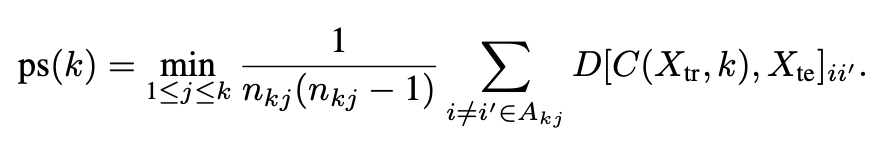

- For each of the test clusters, we calculate the proportion of observation pairs in that cluster that are also assigned to the same cluster using the training set centroids. The prediction strength is the minimum of this quantity over the k test clusters.

In [2]:
def get_closest_centroid(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    min_distance = sys.float_info.max
    min_centroid = 0
    
    for c in centroids:
        dist = distance.euclidean(obs, c)
        if dist < min_distance:
            min_distance = dist
            min_centroid = c
            
    return min_centroid

def get_prediction_strength(k, train_centroids, x_test, test_labels):
    '''
    Function for calculating the prediction strength of clustering
    
    Parameters
    ----------
    k : int
        The number of clusters
    train_centroids : array
        Centroids from the clustering on the training set
    x_test : array
        Test set observations
    test_labels : array
        Labels predicted for the test set
        
    Returns
    -------
    prediction_strength : float
        Calculated prediction strength
    '''
    n_test = len(x_test)
    
    # populate the co-membership matrix
    D = np.zeros(shape=(n_test, n_test))
    for x1, c1 in zip(x_test, list(range(n_test))):
        for x2, c2 in zip(x_test, list(range(n_test))):
            # checks not to be the same sample
            if tuple(x1) != tuple(x2):
                # when 2 samples are part of the same centroid in the matrix of samples they are assigned to 1.
                if tuple(get_closest_centroid(x1, train_centroids)) == tuple(get_closest_centroid(x2, train_centroids)):
                    D[c1, c2] = 1.0
    
    # calculate the prediction strengths for each cluster
    ss = []
    for j in range(k):
        s = 0
        for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
            # Currently checking cluster <j>
            if l1 != j:
                continue
            for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
                # checks if 2 differents samples were marked as part of the
                # same cluster. If they were, consults the co-membership matrix
                # to add 1 point if they were part of the same cluster thanks to the
                # euclidian vector, otherwise the sum do not modify the cluster prediction strengths.
                if tuple(x1) != tuple(x2) and l1 == l2:
                    s += D[c1,c2]
               
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        examples_product = n_examples_j * (n_examples_j - 1)
        
        if examples_product == 0:
            ss.append(math.inf)
        else:
            ss.append(s / examples_product) 

    prediction_strength = min(ss)

    return prediction_strength

In [3]:
df = pd.read_csv('parliament2015.csv', usecols = lambda col : col not in ['name'])
# apply normalization techniques
X = df.copy()
# scaler = MinMaxScaler()
# X[X.columns] = scaler.fit_transform(X[X.columns])
# separete original sample into train and test
X_train, X_test = train_test_split(X, test_size = .15, random_state = 73)

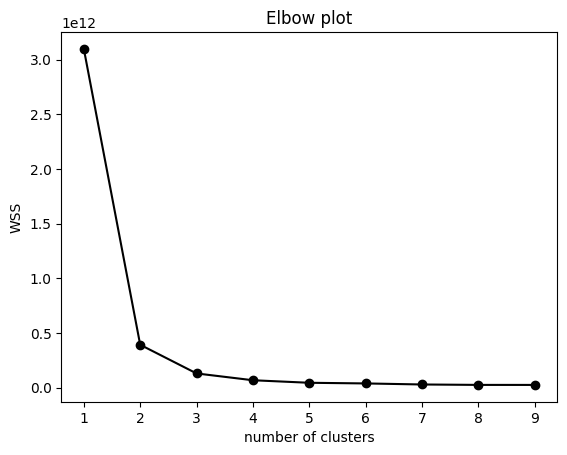

In [4]:
# setting the range of k
clusters = range(1, 10)

# running the clustering 
wss_list = []

for k in clusters:
    model = skcluster.KMeans(n_clusters=k, n_init = 10, max_iter = 10,
            init = 'random', random_state=73)
    model.fit(X)
    wss_list.append(model.inertia_)

# plotting
_, ax = plt.subplots()
ax.plot(clusters, wss_list, '-o', color='black')
ax.set(title='Elbow plot', 
       xlabel='number of clusters', 
       ylabel='WSS');

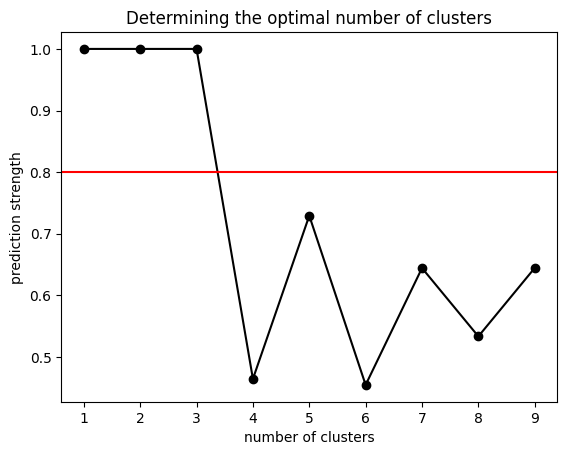

In [5]:
# setting the range of k
clusters = range(1, 10)
strengths = []

collect = {}

# running the clustering 
for k in clusters:
    model_train = skcluster.KMeans(n_clusters = k, random_state = 73).fit(X_train)
    model_test = skcluster.KMeans(n_clusters = k, random_state = 73).fit(X_test) 
    
    pred_str = get_prediction_strength(k, model_train.cluster_centers_, X_test.to_numpy(), model_test.labels_)
    strengths.append(pred_str)
    data = {
        'strength': pred_str,
        'centroids': model_train.cluster_centers_,
        'means': X_train.mean().to_numpy(),
        'stds': X_train.std().to_numpy()
    }
    collect[str(k)] = data
    
# From the plot, I can clarly see that the 
# recommended number of clusters is 3.

# plotting
_, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red');
ax.set(title='Determining the optimal number of clusters', 
       xlabel='number of clusters', 
       ylabel='prediction strength');

In [6]:
# automation to save the number of clusters and the centroids.

kcluster, scluster = -1, -1
for s, k in zip(strengths, clusters):
    if s >= scluster:
        scluster, kcluster = s, k
    if s < scluster:
        break

kdata = collect[str(kcluster)] 

centroids = kdata['centroids']
means = kdata['means']
stds = kdata['stds']

def np_to_str(x):
    x = np.around(x, decimals=2)
    str_np = str(x)
    replace = ['\n', '[', ']']
    for r in replace:
        str_np = str_np.replace(r, '')
    return str_np.strip()

with open('parameters.out', 'w+') as f:
    f.write(str(kcluster))
    f.write('\n')
    for c in centroids:
        f.write(np_to_str(c))
        f.write('\n')

In [7]:
def line_to_centroid(line):
    '''
    Parameters
    ----------
    line : str
    
    Returns
    -------
    centroid : array
    '''
    line = line.replace('\n', '')
    x = line.split(' ')
    x = list(filter(lambda x : x != '', list(x)))
    x = np.array(x)
    return x.astype(float)

X = pd.read_csv('testing.csv')
centroids = []

with open('parameters.out', 'r') as f:
    line = f.readline()
    k = int(line)
    for i in range(k):
        line = f.readline()
        c = line_to_centroid(line)
        centroids.append(c)
        
colors = map(lambda x : (x[0] + 1, x[1]), enumerate(centroids))
colors = list(colors)

solution = []
    
for _, sample in X.iterrows():
    centroid = get_closest_centroid(sample, centroids)
    color = next(x[0] for x in colors if tuple(x[1]) == tuple(centroid))
    solution.append(color)

with open('solution.out', 'w+') as f:
    for s in solution:
        f.write(str(s))
        f.write('\n')

## Execise 2

In [11]:
%run 'kmeans_class.py'

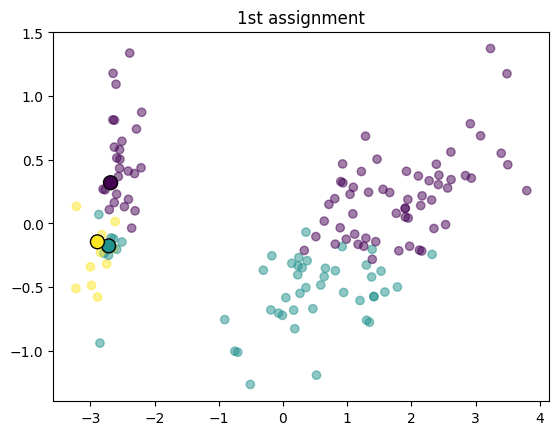

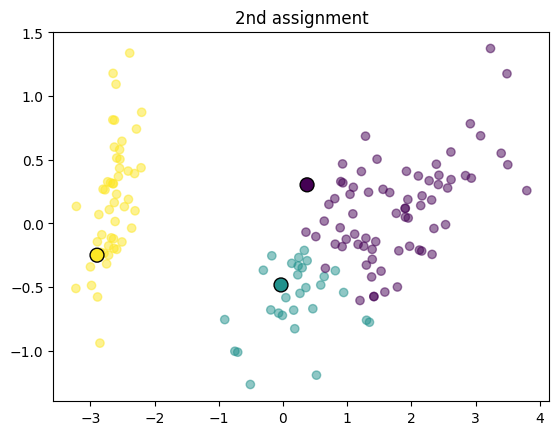

<Figure size 640x480 with 0 Axes>

In [9]:
X = datasets.load_iris().data
np.random.seed(1)
K = 3
km = Kmeans(X, K)

S0 = X[(0,1,2),:]

km = km.set_centers(S0)
km = km.assignment_step()
km.plot("1st assignment")
km = km.updating_step().assignment_step()
km.plot("2nd assignment")

## Exercise 3

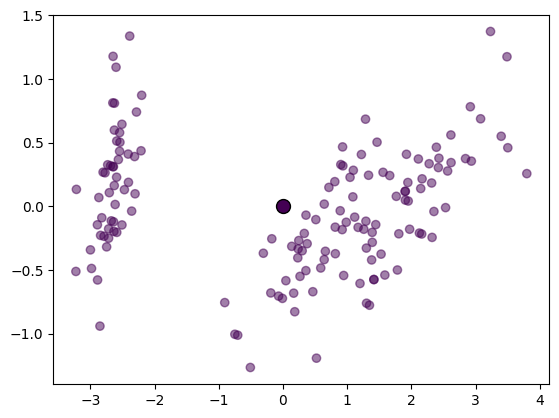

<Figure size 640x480 with 0 Axes>

In [12]:
mean_ = Kmeans(X, K = 1)
mean_.set_centers(np.array([X[0,:]]))
for i in range(X.shape[0]):
  x = X[i,:]
  mean_ = mean_.sequential_step(x, 1/(i+1))

mean_.plot()